In [1]:
import sys
import numpy as np

import imexam

from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u

from photutils import DAOStarFinder, CircularAperture
from scipy.ndimage import shift
from ccdproc import CCDData, Combiner, subtract_overscan, trim_image
from astroquery.mast import Catalogs
from reproject import reproject_interp

from glob import glob

import matplotlib

%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# Local file import 
sys.path.append('../src')
import pixworld2wcs

# Image Alignment Using V-band Images

## Step 1: getting some good images to make our template

#### Getting a list of v-band image files

In [3]:
dataDir = "../data/NGC1866_images/"

In [8]:
fitsFiles = glob(dataDir + "*fits")
fitsFiles = [x for x in fitsFiles if "align" not in x]

In [9]:
filesByWaveband = dict()

for fle in fitsFiles:
    band = fits.getheader(fle)['FILTER']
    if not filesByWaveband.get(band):
        filesByWaveband[band] = [fle]
    filesByWaveband[band].append(fle)

### Using imexam to explore the images

We'll go through the V-band images and pick out the best ones to use in our template

In [10]:
print("Number of V-band images: {}".format(len(filesByWaveband['V'])))

Number of V-band images: 34


The imexam tasks we will use:
- **a**   Aperture sum, with radius region_size
- **e**   Return a contour plot in a region around the cursor
- **m**   Square region stats, in \[region_size\],default is median
- **r**   Return the radial profile plot

#### Setting up the viewer

In [7]:
ds9viewer=imexam.connect('ac110675:54954')
ds9viewer.scale("log")
ds9viewer.scale("minmax")

In [8]:
ds9viewer.set_plot_pars('r','rplot',25)
ds9viewer.rimexam()

set radial_profile_pars: rplot to 25


{'function': ['radial_profile'],
 'title': [None, 'Title of the plot'],
 'xlabel': ['Radius', 'The string for the xaxis label'],
 'ylabel': ['Flux', 'The string for the yaxis label'],
 'pixels': [True, 'Plot all pixels at each radius? (False bins the data)'],
 'fitplot': [False, 'Overplot profile fit?'],
 'fittype': ['Gaussian2D', 'Profile type to fit (Gaussian2D)'],
 'center': [True, 'Solve for center using 2d Gaussian? [bool]'],
 'background': [False, 'Subtract background? [bool]'],
 'skyrad': [10.0, 'Background inner radius in pixels, from center of object'],
 'width': [5.0, 'Background annulus width in pixels'],
 'magzero': [25.0, 'magnitude zero point'],
 'rplot': [25, 'Plotting radius in pixels'],
 'pointmode': [True, 'plot points instead of lines? [bool]'],
 'marker': ['o', 'The marker character to use, matplotlib style'],
 'getdata': [False, 'print the plotted data values']}

In [9]:
ds9viewer.set_plot_pars('e','ncolumns',20)
ds9viewer.set_plot_pars('e','nlines',20)
ds9viewer.eimexam()

set contour_pars: ncolumns to 20
set contour_pars: nlines to 20


{'function': ['contour'],
 'title': [None, 'Title of the plot'],
 'xlabel': ['x', 'The string for the xaxis label'],
 'ylabel': ['y', 'The string for the yaxis label'],
 'ncolumns': [20, 'Number of columns'],
 'nlines': [20, 'Number of lines'],
 'floor': [None, 'Minimum value to be contoured'],
 'ceiling': [None, 'Maximum value to be contoured'],
 'ncontours': [8, 'Number of contours to be drawn'],
 'linestyle': ['--', 'matplotlib linestyle'],
 'label': [True, 'Label major contours with their values? [bool]'],
 'cmap': ['viridis', 'Colormap (matplotlib style) for image']}

In [230]:
ds9viewer.set_plot_pars('a','radius',12)
ds9viewer.set_plot_pars('a','skyrad',20)
ds9viewer.aimexam()

set aper_phot_pars: radius to 12
set aper_phot_pars: skyrad to 20


{'function': ['aper_phot'],
 'center': [True, 'Center the object location using a 2d gaussian fit'],
 'width': [5, 'Width of sky annulus in pixels'],
 'subsky': [True, 'Subtract a sky background?'],
 'skyrad': [20, 'Distance to start sky annulus is pixels'],
 'radius': [12, 'Radius of aperture for star flux'],
 'zmag': [25.0, 'zeropoint for the magnitude calculation']}

In [11]:
ds9viewer.set_plot_pars('m','region_size',12)
ds9viewer.mimexam()

set report_stat_pars: region_size to 12


{'function': ['report_stat'],
 'stat': ['median', 'numpy stat name or describe for scipy.stats'],
 'region_size': [12, 'region size in pixels to use']}

#### Looking at the images

Output shown here is just an example, as I used the same cells to look at all the images.

In [79]:
ds9viewer.load_fits(filesByWaveband['V'][0])


Press 'q' to quit

2	Make the next plot in a new window
a	Aperture sum, with radius region_size 
b	Return the 2D gauss fit center of the object
c	Return column plot
e	Return a contour plot in a region around the cursor
g	Return curve of growth plot
h	Return a histogram in the region around the cursor
j	1D [Gaussian1D default] line fit 
k	1D [Gaussian1D default] column fit
l	Return line plot
m	Square region stats, in [region_size],default is median
r	Return the radial profile plot
s	Save current figure to disk as [plot_name]
t	Make a fits image cutout using pointer location
w	Display a surface plot around the cursor location
x	Return x,y,value of pixel
y	Return x,y,value of pixel
Current image /Users/cbrasseur/Documents/ljmu/CepheidVariables/data/NGC1866_images/coj2m002-fs01-20151005-0026-e90.fits
Invalid key
contour centered at: 1646.5683 1120.4627


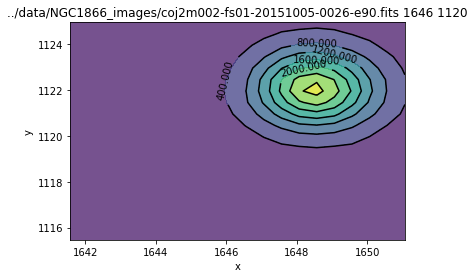

contour centered at: 1561.9654 1217.5072


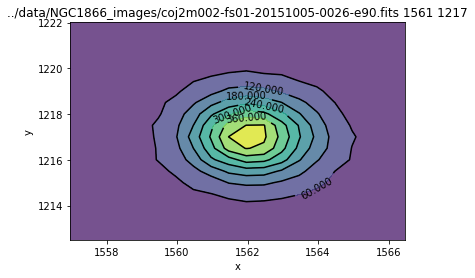

contour centered at: 1226.0422 1528.5472


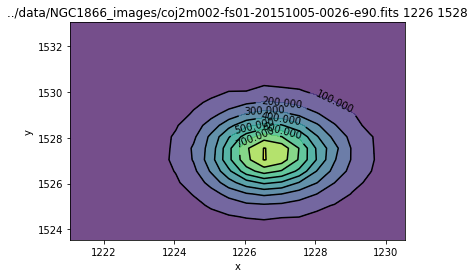

xc=1649.857718	yc=1126.635262


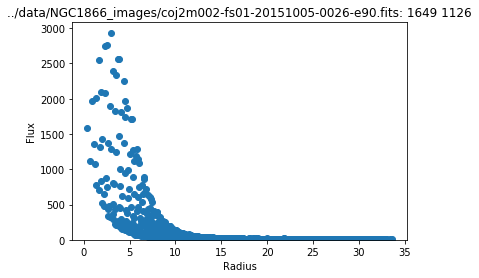

xc=1561.267081	yc=1216.039845


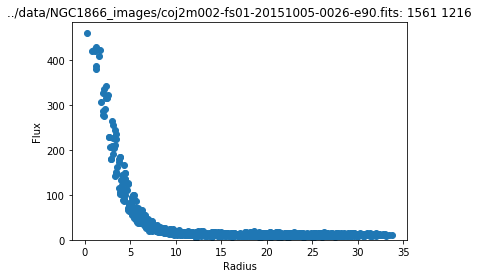

xc=1227.314982	yc=1525.553926


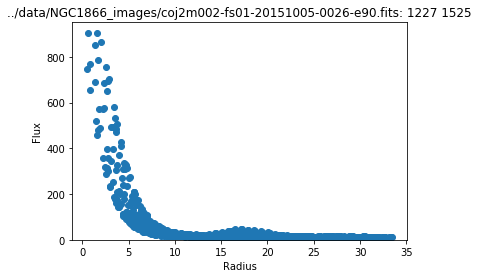

xc=1649.903717	yc=1123.196840
x              y              radius         flux           mag(zpt=25.00)sky             fwhm
1649.90        1123.20        12             126747.03      12.24                         12.15          6.16
xc=1561.260887	yc=1216.041720
x              y              radius         flux           mag(zpt=25.00)sky             fwhm
1561.26        1216.04        12             20309.62       14.23                         11.23          6.50
xc=1227.293102	yc=1525.552548
x              y              radius         flux           mag(zpt=25.00)sky             fwhm
1227.29        1525.55        12             40264.09       13.49                         11.96          6.27
[1119:1131,1640:1652] median: 229.010986328125
[1211:1223,1555:1567] median: 91.50466918945312
[1520:1532,1220:1232] median: 165.60751342773438


In [80]:
ds9viewer.imexam()

#### Deciding on list of images to use in the template image
Using the radial profile and countour plots, and the aperture sum and square region stats I picked the following 7 images to use in the template:

In [11]:
templateImgs = [filesByWaveband['V'][i] for i in [3,13,15,16,18,26,30]]

## Step 2: Finding objects in the template images

We'll use DAOStarFinder to create catalogs for each image

#### Just working with part of one image for proof of concept

In [12]:
hdu = fits.open(templateImgs[0])
data = hdu[0].data[750:1250,750:1250]
mean, median, std = sigma_clipped_stats(data, sigma=3.0, iters=5)    
print((mean, median, std)) 
hdu.close()

(7.2394732191626767, 7.0399642, 2.9671371103365898)


In [13]:
daofind = DAOStarFinder(fwhm=6.2, threshold=5.*std)
sources = daofind(data - median)

In [14]:
print("Number of sources: {}".format(len(sources)))
sources[:10]

Number of sources: 460


<Table length=10>
  id    xcentroid     ycentroid   ...      flux           mag      
int64    float64       float64    ...    float64        float64    
----- ------------- ------------- ... ------------- ---------------
    1 16.9349821143 2.80467278217 ... 1.13509056098 -0.137576280617
    2 252.822414815 6.34742736167 ...  1.5832000624 -0.498839495787
    3 29.8487128211 8.48641715565 ... 2.29758061912 -0.903176897886
    4 55.6712012573 8.94547505967 ...  1.5435060958 -0.471270872477
    5 437.824717193 12.1324559974 ... 7.14265162229   -2.1346486706
    6  124.35457683 14.5339661267 ... 1.63038036135 -0.530722338566
    7 166.180373794 19.2646928595 ... 1.57776352697 -0.495104780723
    8 403.999402896 19.1160824323 ... 1.45303689168 -0.405691602245
    9  199.10658243 21.9163059338 ... 2.27397238618 -0.891962966401
   10 281.108620184 26.5142426446 ... 5.10034700422  -1.76899931127

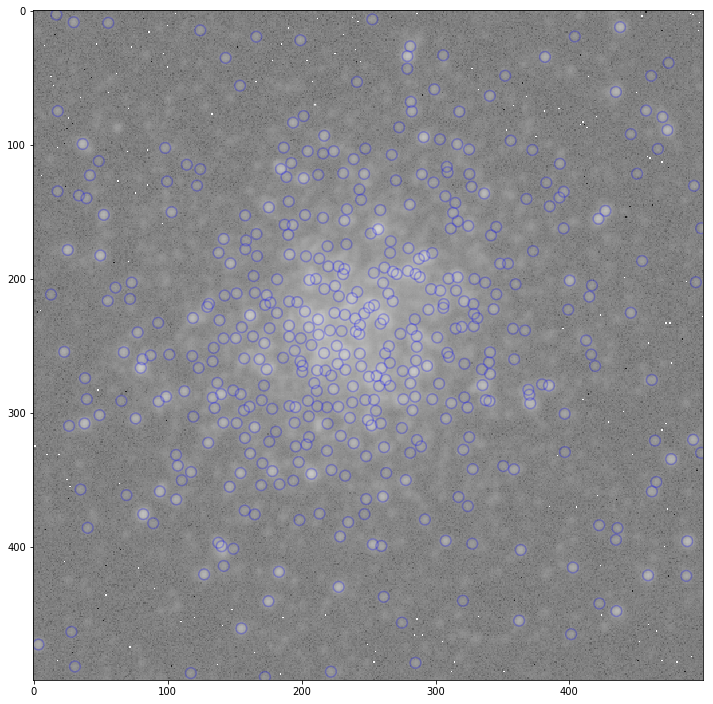

In [15]:
fig = plt.figure(figsize=(12,112))
ax = fig.add_subplot(111)

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=4.)
norm = LogNorm(vmin=0.01,vmax=3000)
ax.imshow(data, cmap='gray', norm=norm)
apertures.plot(color='blue', lw=1.5, alpha=0.25, ax=ax)

That looks pretty good, now we'll do it for all of the images.

### Making a class to hold all the information we need for each image

In [16]:
class ImageInfo:
    """
    Class to hold all the information for aligning a fits image file.
    
    The fits file is assumed to have one extension with WCS info in the header and an image array for data.
    """
    
    filename = None
    
    initial_image = None
    initial_header = None
    initial_wcs = WCS()
    
    corrected_image = None
    corrected_wcs = WCS()
    
    catalog = Table()
    fixed_stars = Table()
    
    mean = None
    median = None
    std = None
    fwhm = None
    
    
    def __init__(self,filename):
        self.filename = filename
        self.initial_image = fits.getdata(filename,0)
        self.initial_header = fits.getheader(filename,0)
        self.initial_wcs = WCS(filename)
    

#### Initializing the class for each file

In [17]:
template_images = [ImageInfo(fle) for fle in templateImgs]

While examining all the images with imexam, one of the things I kept track of was the fwhm for each image, so I will now add that information to the classes manually.

In [18]:
template_fwhm = [6.2,3.9,3.15,4.5,2.5,3,3.35] # obtained with imexamin
for i,img in enumerate(template_images):
    img.fwhm = template_fwhm[i]

### Making a catalog for each image

We'll follow the same steps we did for the test image for the entirety of each template image.

In [19]:
for img in template_images: 
    img.mean, img.median, img.std = sigma_clipped_stats(img.initial_image, sigma=3.0, iters=5)
    
    daofind = DAOStarFinder(fwhm=img.fwhm, threshold=5.*img.std)
    img.catalog = daofind(img.initial_image - img.median)

## Step 3: Correcting image WCS info

We will use the Gaia catalog to get accurate sky coordinates for a number of stars in the images. We will use those stars and their corresponding x,y pixel coordinates in each individual image to create a corrected WCS object.

I am proceeding assuming that distortion effects are small enough I don't have to worry about them (this seems to be reasonable based on manual inspection).

### Getting pixel coordinates for target stars

In the end, I used seven target stars to create the corrected WCS info. I got the pixel values using the aperture sum functionality from imexamin. Below is example output from one such session, but again, I used the same cells repeatedly, and they aren't that illuminating anyway.

In [71]:
ds9viewer=imexam.connect('c0a80121:61842')
ds9viewer.scale("log")
ds9viewer.scale("minmax")

In [72]:
ds9viewer.set_plot_pars('a','radius',12)
ds9viewer.set_plot_pars('a','skyrad',20)
ds9viewer.aimexam()

set aper_phot_pars: radius to 12
set aper_phot_pars: skyrad to 20


{'function': ['aper_phot'],
 'center': [True, 'Center the object location using a 2d gaussian fit'],
 'width': [5, 'Width of sky annulus in pixels'],
 'subsky': [True, 'Subtract a sky background?'],
 'skyrad': [20, 'Distance to start sky annulus is pixels'],
 'radius': [12, 'Radius of aperture for star flux'],
 'zmag': [25.0, 'zeropoint for the magnitude calculation']}

In [73]:
ds9viewer.load_fits(templateImgs[5])

In [79]:
ds9viewer.imexam()


Press 'q' to quit

2	Make the next plot in a new window
a	Aperture sum, with radius region_size 
b	Return the 2D gauss fit center of the object
c	Return column plot
e	Return a contour plot in a region around the cursor
g	Return curve of growth plot
h	Return a histogram in the region around the cursor
j	1D [Gaussian1D default] line fit 
k	1D [Gaussian1D default] column fit
l	Return line plot
m	Square region stats, in [region_size],default is median
r	Return the radial profile plot
s	Save current figure to disk as [plot_name]
t	Make a fits image cutout using pointer location
w	Display a surface plot around the cursor location
x	Return x,y,value of pixel
y	Return x,y,value of pixel
Current image /Users/cbrasseur/Documents/ljmu/CepheidVariables/data/NGC1866_images/coj2m002-fs01-20160130-0118-e90.fits
xc=206.207664	yc=1158.893520
x              y              radius         flux           mag(zpt=25.00)sky             fwhm
206.21         1158.89        12             11622.58       14.84  

I probably could have been more clever and used the catalogs I made with DAOStarFinder to get these coordinates, but instead I just used imexam, wrote everything down, and inserted the information manually.

In [20]:
template_images[0].fixed_stars = Table()
template_images[0].fixed_stars['x'] = [1637.73,1549.20,1215.26,1805.46,1753.02,226.30,1689.12]
template_images[0].fixed_stars['y'] = [1106.72,1199.47,1508.84,1573.69,1677.15,1159.18,72.71]

template_images[1].fixed_stars = Table()
template_images[1].fixed_stars['x'] = [1601.63,1513.03,1178.98,1769.20,1716.72,190.05,1653.08]
template_images[1].fixed_stars['y'] = [1119.16,1211.92,1521.38,1586.22,1689.80,1171.74,85.28]

template_images[2].fixed_stars = Table()
template_images[2].fixed_stars['x'] = [1643.54,1554.91,1220.94,1811.21,1758.73,231.90,1694.83]
template_images[2].fixed_stars['y'] = [1120.55,1213.36,1522.87,1587.73,1691.23,1173.15,86.40]

template_images[3].fixed_stars = Table()
template_images[3].fixed_stars['x'] = [1660.11,1571.49,1237.58,1827.83,1775.32,248.59,1711.35]
template_images[3].fixed_stars['y'] = [1126.31,1219.14,1528.72,1593.58,1697.19,1178.83,92.46]

template_images[4].fixed_stars = Table()
template_images[4].fixed_stars['x'] = [1632.72,1544.09,1210.05,1800.38,1747.94,221.06,1683.91]
template_images[4].fixed_stars['y'] = [1116.00,1208.76,1518.35,1583.14,1686.71,1168.68,83.49]

template_images[5].fixed_stars = Table()
template_images[5].fixed_stars['x'] = [1616.98,1529.28,1186.25,1785.53,1733.07,206.21,1669.21]
template_images[5].fixed_stars['y'] = [1275.33,1199.15,1405.49,1573.42,1676.94,1158.89,72.54]
        
template_images[6].fixed_stars = Table()
template_images[6].fixed_stars['x'] = [1636.46,1547.80,1213.72,1804.06,1751.55,224.82,1687.86]
template_images[6].fixed_stars['y'] = [1110.84,1203.67,1513.29,1578.03,1681.62,1163.54,76.81]

### Getting the 'canonical' sky positions of the target stars using Gaia

Again, I could maybe have done something clever with catalog crossmatch here, but what I actually did is open up ESASky (http://sky.esa.int/), search for NGC 1866, load the Gaia sources on top and find the ones that corresponed to the stars I picked out.  Then I added these coordinates in manually.

In [21]:
for img in template_images:
    img.fixed_stars['ra'] = [78.28064,78.29842,78.36535,78.24656,78.25705,78.56488,78.27106]
    img.fixed_stars['dec'] = [-65.45482,-65.44702,-65.421,-65.41576,-65.4071,-65.4497,-65.54136]
    img.fixed_stars['coord'] = SkyCoord(img.fixed_stars['ra'], img.fixed_stars['dec'], unit=u.deg) # for wcs fitting

We will also want to use the Gaia catalog over the same region as our images, so I will go ahead and grab that as well. (I used the MAST catalog interface in Astroquery insteat of the Gaia one just because I am more familier with it.)

Figuring out the radius to search (rough is fine):

In [22]:
center_ra,center_dec = template_images[0].initial_wcs.wcs.crval
corner_ra,corner_dec =  template_images[0].initial_wcs.wcs_pix2world(0,0,0)
approx_radius = ((corner_ra - center_ra)**2 + (corner_dec - center_dec)**2)**0.5
print(approx_radius)

0.223246917626


Performing the catalog search

In [23]:
coord = SkyCoord(ra=center_ra, dec=center_dec, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(0.23, u.deg)

In [25]:
# There is a @#^&@#%^& newly introduced bug in the Gaia request that I will be fixing this week (sigh)
#gaiaCatalog = Catalogs.query_region(coord,radius,"Gaia")
service = "Mast.Catalogs.GaiaDR2.Cone"
params = {'ra':center_ra,
          'dec':center_dec,
          'radius':0.23}

gaiaCatalog = Catalogs.service_request(service,params)

We are going to want a sky coordinate column later on, so we will go ahead and add it now.

In [26]:
gaiaCatalog['coord'] = SkyCoord(gaiaCatalog['ra'],gaiaCatalog['dec'],unit=u.deg)

In [27]:
print("Number of Gaia sources: {}".format(len(gaiaCatalog)))
gaiaCatalog[:5]

Number of Gaia sources: 39736


<Table masked=True length=5>
    solution_id     ...                coord                
                    ...               deg,deg               
       str19        ...                object               
------------------- ... ------------------------------------
1635721458409799680 ...  78.4120422421089,-65.46522409557878
1635721458409799680 ... 78.41126002918035,-65.46516358788776
1635721458409799680 ... 78.41260076795707,-65.46537727371351
1635721458409799680 ... 78.41342134118486,-65.46503052265857
1635721458409799680 ...  78.41044989928061,-65.4648695903287

### Correcting the WCS info

For this I will Clare Shanahan's wcs fitting software (on github: https://github.com/shannnnnyyy/wcs_fitting).  

#### Starting with the first image

In [28]:
correctedWcs = pixworld2wcs.wcs_pixworld2wcs(template_images[0].fixed_stars)
correctedWcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 78.326279999999997  -65.448108571428577  
CRPIX : 1410.8700000000001  1185.3942857142854  
PC1_1 PC1_2  : -8.3676362489365459e-05  -3.6767872513872976e-07  
PC2_1 PC2_2  : -4.4939615300337559e-07  8.3687963877083739e-05  
CDELT : 1.0  1.0  
NAXIS : 0  0

Before we go with this, let's plot it up with the Gaia sources overlayed for a sanity check. 

We will limit the catalog to sources brighter than magnitude 17 so as not to everwhelm the plot (also a lot of the fainter sources aren't visible in our image anyway).

We'll put the plotting into a function since we are definitely going to want to use it again.

In [29]:
def plotSourcesOverImage(source_x,source_y,img):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    positions = (source_x,source_y)
    apertures = CircularAperture(positions, r=10)
    norm = LogNorm(vmin=0.01,vmax=3000)
    ax.imshow(img, cmap='gray', norm=norm)
    apertures.plot(color='blue', lw=1.5, alpha=0.5, ax=ax)

In [30]:
x,y = correctedWcs.wcs_world2pix(gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['ra'],
                                 gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['dec'],0)

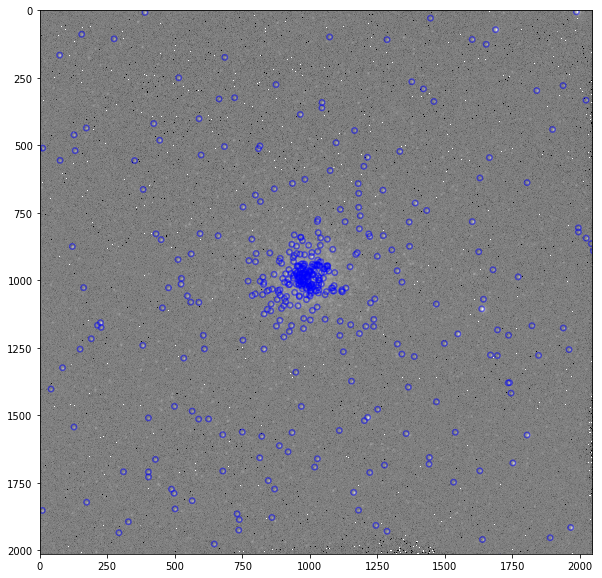

In [31]:
plotSourcesOverImage(x,y,template_images[0].initial_image)

This look pretty good. The sources aren't exactly spot on and there are a couple missing, but it's certainly a reasonable start. Now lets do a catalog crossmatch between Gaia and the image catalog and look at the distance histogram.

First we need to get the ras and decs of the image sources based on the new WCS:

In [32]:
ras,decs = correctedWcs.wcs_pix2world(template_images[0].catalog['xcentroid'],
                                      template_images[0].catalog['ycentroid'],0)
imgcoords = SkyCoord(ras,decs,unit=u.deg)

Now we can perform the crossmatch. I'm going to again use only bright Gaia stars so I don't get a lot of stars that have no match because they are too faint to show up in the image catalog.

In [33]:
idx, d2d, d3d = gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['coord'].match_to_catalog_sky(imgcoords)

And we'll put the histogram plotting in another function so we can reuse it.

Figuring out the FWHM in arcsec (taking it to be about 6.5 pixels)

In [34]:
ptOne = correctedWcs.wcs_pix2world(0,0,0)
ptTwo = correctedWcs.wcs_pix2world(0,6.5,0)
((ptOne[1]-ptTwo[1])*u.degree).to(u.arcsec)

<Quantity -1.958229131156486 arcsec>

In [35]:
def plotSepHist(d2d):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.tick_params(axis='both', which='major', labelsize=14)
 
    ax.hist(d2d.arcsec, bins=40, range=(0,20),edgecolor='black',  linewidth=2,histtype='stepfilled', color="#d5d5d5")

    ax.axvline(2) # putting in a line at the fwhm
    ax.set_xlabel('separation [arcsec]',fontsize=14)

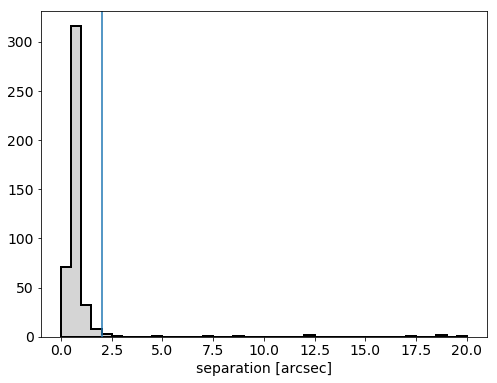

In [36]:
plotSepHist(d2d)

Well that looks good! Nice peak under the fwhm, and then a few things further out that are most likely misidentifications. We'll go ahead and add the corrected WCS to the image object and do the rest of the images.

In [37]:
template_images[0].corrected_wcs = correctedWcs

In [38]:
for img in template_images[1:]: 
    img.corrected_wcs = pixworld2wcs.wcs_pixworld2wcs(img.fixed_stars)

Oops, let's see which fit has problems:

In [39]:
pixworld2wcs.wcs_pixworld2wcs(template_images[5].fixed_stars)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 78.326279999999997  -65.448108571428577  
CRPIX : 1389.5042857142855  1194.537142857143  
PC1_1 PC1_2  : -8.3656311176635037e-05  -2.1678881931503973e-06  
PC2_1 PC2_2  : -4.8606530173226586e-06  8.9383121584533438e-05  
CDELT : 1.0  1.0  
NAXIS : 0  0

OK, we'll keep an eye on that one, see if it causes problem later.

Now, let's look at the fits:

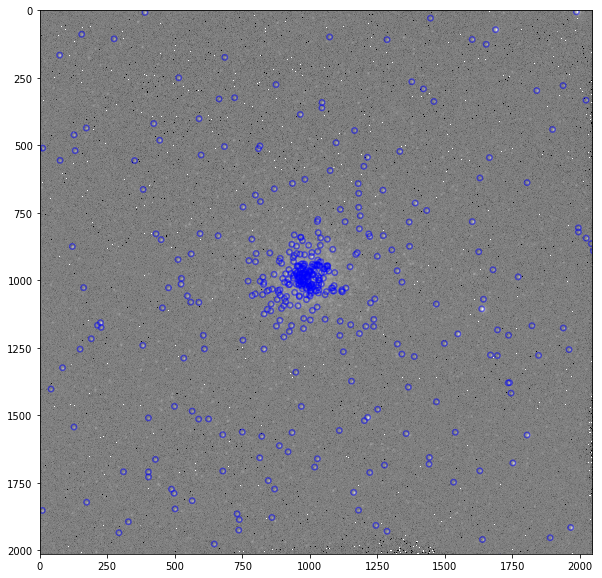

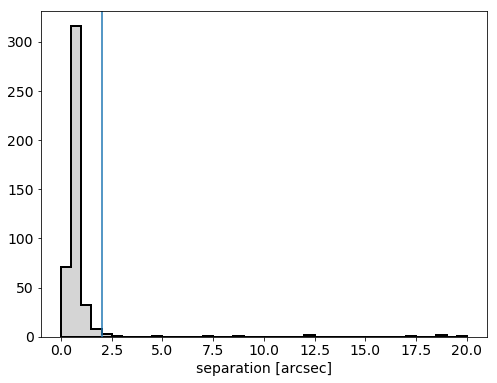

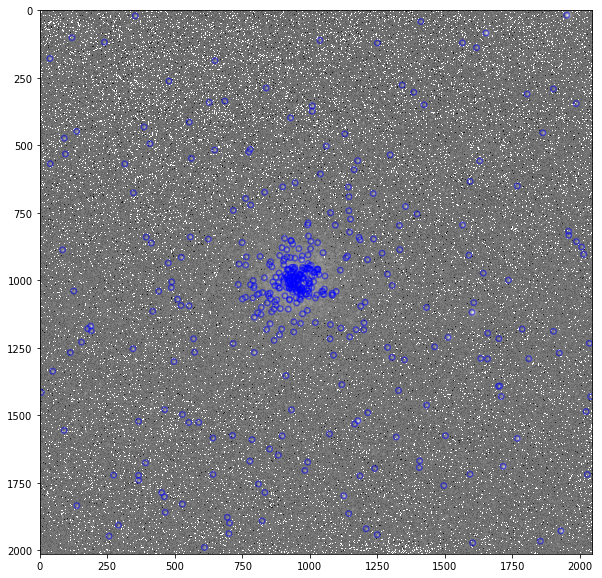

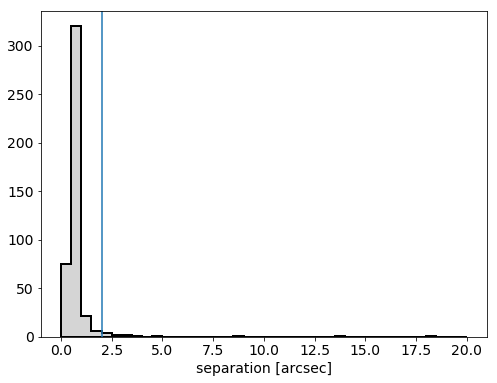

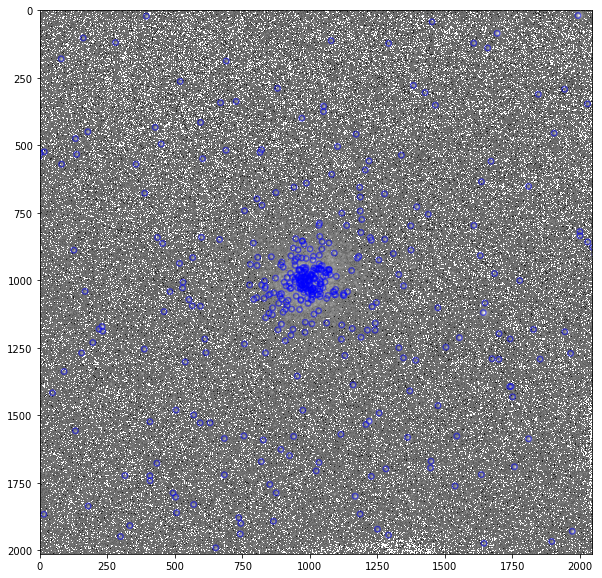

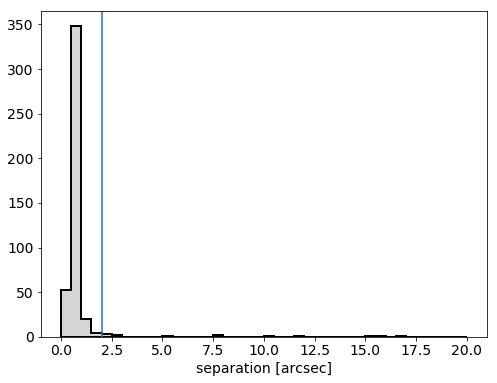

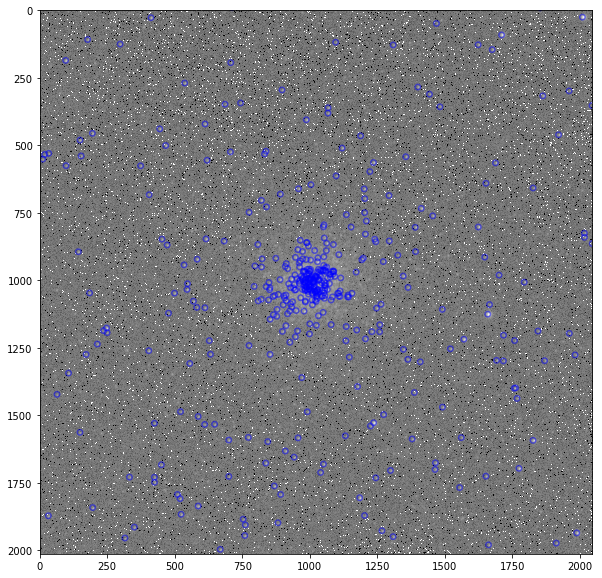

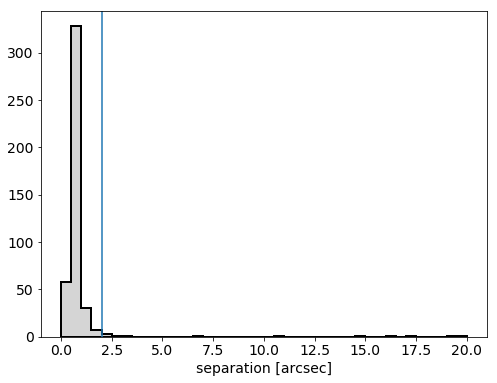

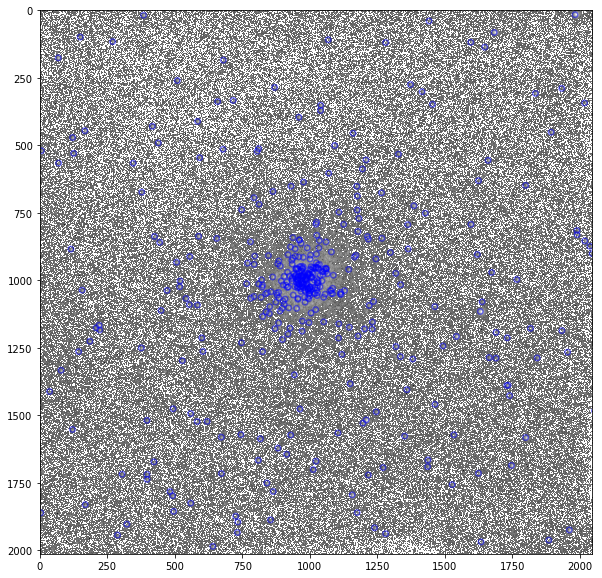

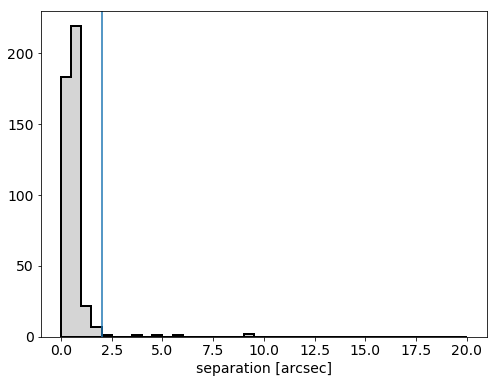

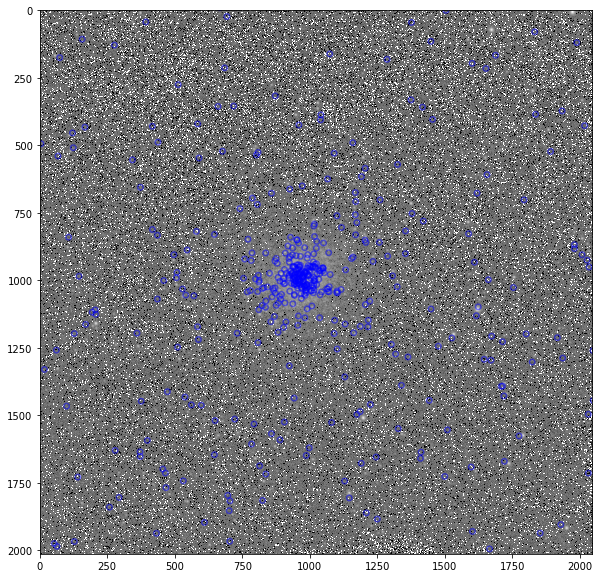

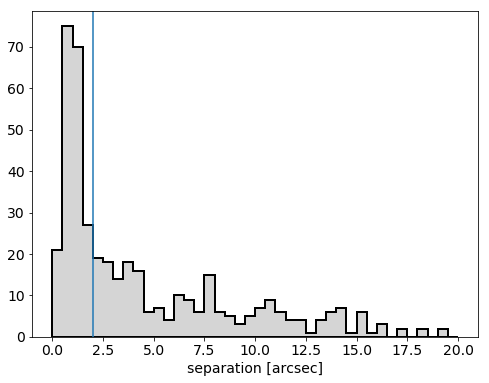

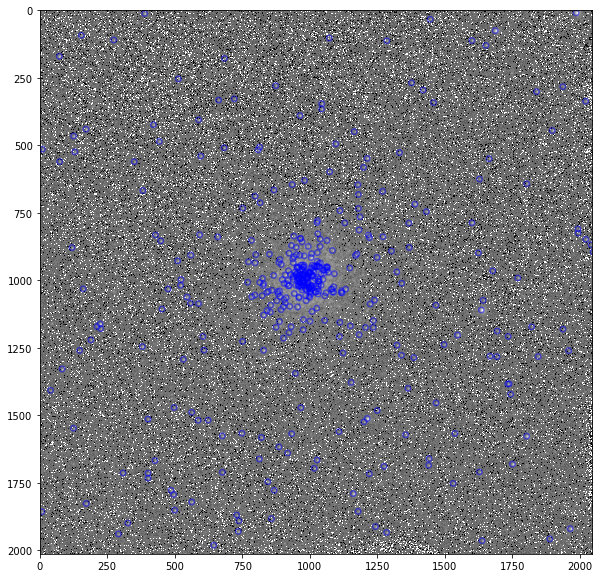

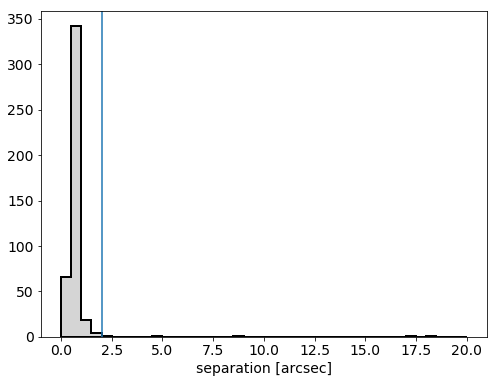

In [41]:
for img in template_images: 

    x,y = img.corrected_wcs.wcs_world2pix(gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['ra'],
                                          gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['dec'],0)
    
    plotSourcesOverImage(x,y,img.initial_image)
    
    ras,decs = img.corrected_wcs.wcs_pix2world(img.catalog['xcentroid'],img.catalog['ycentroid'],0)
    imgcoords = SkyCoord(ras,decs,unit=u.deg)
    
    idx, d2d, d3d = gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['coord'].match_to_catalog_sky(imgcoords)
    plotSepHist(d2d)

We can definitely see that image 5 was not as successfully fit at the rest.  For now I will simply not use this image in the template, later I will go back and try to do a better fit, most likely by using additional target stars.

## Step 4: Reproject all the images onto a single projection

We'll project all of the imaged onto the first image using reproject (https://reproject.readthedocs.io).

#### Again I'll start with reprojecting a single image for proof of concept

In [42]:
array, footprint = reproject_interp((template_images[1].initial_image,template_images[1].corrected_wcs), 
                                    template_images[0].corrected_wcs, shape_out=template_images[1].initial_image.shape)

/Users/cbrasseur/anaconda/envs/astroconda/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


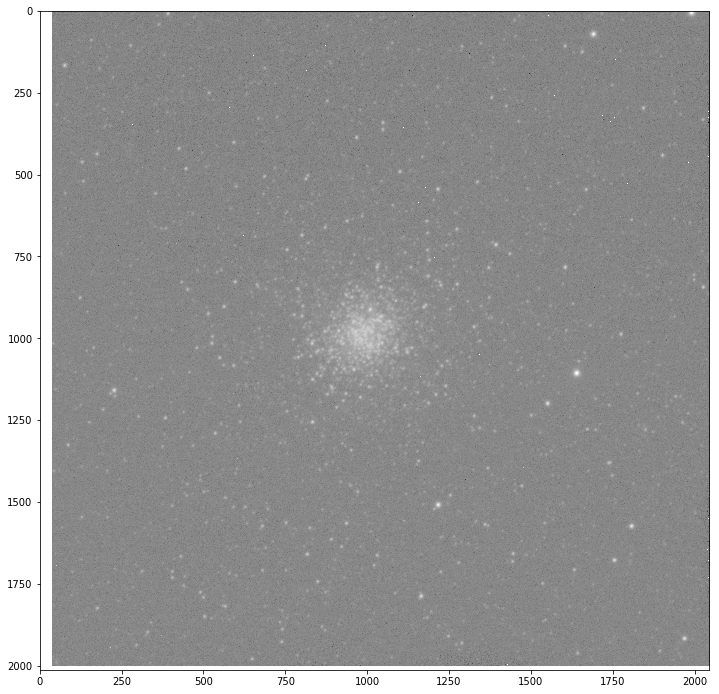

In [43]:
fig = plt.figure(figsize=(12,112))
ax1 = fig.add_subplot(111)

norm = LogNorm(vmin=0.01,vmax=3000)
ax1.imshow(template_images[0].initial_image + array, cmap='gray', norm=norm)

Looks like it worked, so now we can do it for all the images.

**Doing the reproject en masse (onto first image)**

In [44]:
canonical_wcs = template_images[0].corrected_wcs
canonical_shape = template_images[0].initial_image.shape

In [45]:
template_images[0].corrected_image = template_images[0].initial_image # it's the same since proj the rest on this one

In [46]:
for img in template_images[1:]: # don't need to reproject first image, since that's what we are reprojecting on
    array, footprint = reproject_interp((img.initial_image,img.corrected_wcs), canonical_wcs,canonical_shape)
    img.corrected_image = array

## Step 5: Summing the images

Doing a quick and dirty summation of the images (leaving out image 5):

In [47]:
coadded_image = sum([x.corrected_image for x in template_images[:5]] + [template_images[6].corrected_image])

/Users/cbrasseur/anaconda/envs/astroconda/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


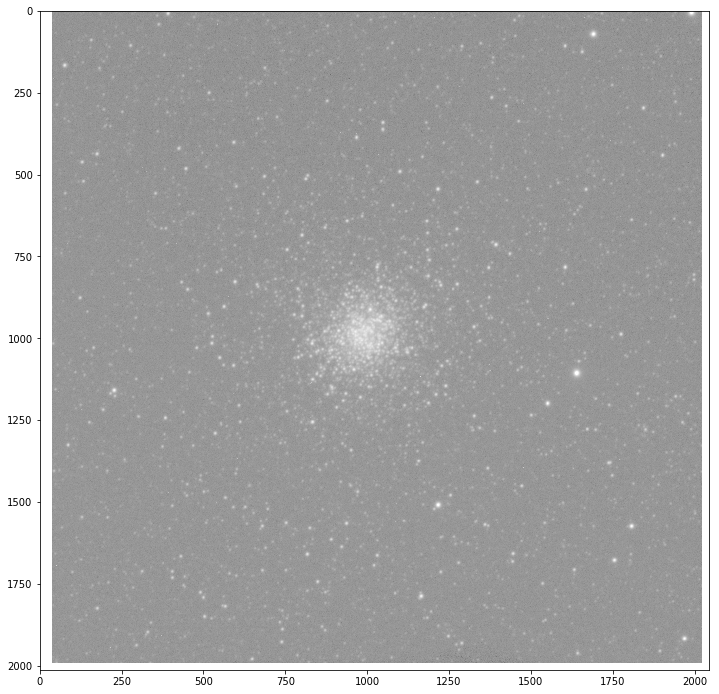

In [48]:
fig = plt.figure(figsize=(12,112))
ax1 = fig.add_subplot(111)

norm = LogNorm(vmin=0.01,vmax=3000)
ax1.imshow(coadded_image, cmap='gray', norm=norm)

That looks pretty good! 

I'm not sure what the warning is for, but my guess is it's having problems with the nans around the edges.

Now what happens if we average rather than just adding?

In [49]:
img_cube = np.array([x.corrected_image for x in template_images[:5]] + [template_images[6].corrected_image])
average_image = np.mean(img_cube,axis=0)

/Users/cbrasseur/anaconda/envs/astroconda/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


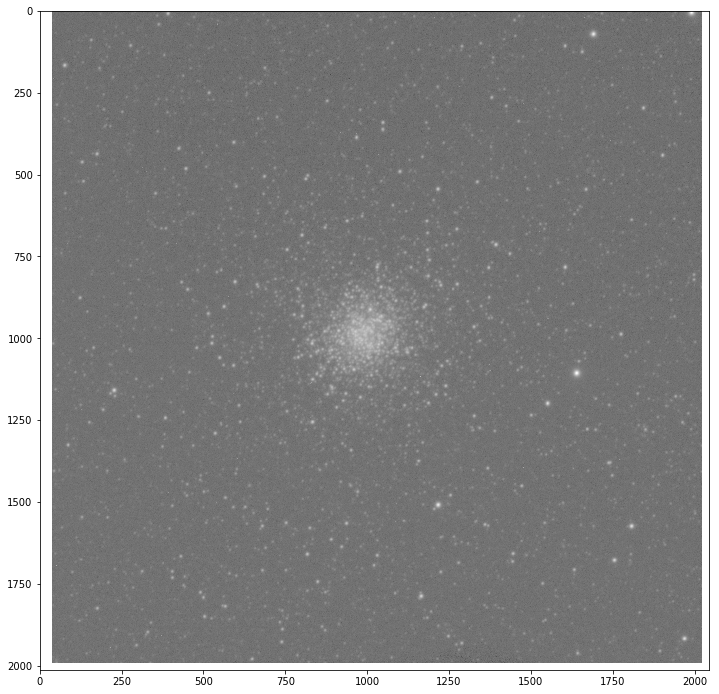

In [50]:
fig = plt.figure(figsize=(12,112))
ax1 = fig.add_subplot(111)

norm = LogNorm(vmin=0.01,vmax=3000)
ax1.imshow(average_image, cmap='gray', norm=norm)

OK, that's good and all, but now lets do cosmic ray rejection when we combine the images

In [161]:
ccdDataFrames =  [CCDData(x, unit=u.dimensionless_unscaled) for x in img_cube]
combiner = Combiner(ccdDataFrames)

In [162]:
combiner.data_arr.mask[np.isnan(combiner.data_arr)]=True

In [163]:
old_n_masked = -1  # dummy value to make loop execute at least once
new_n_masked = combiner.data_arr.mask.sum()

print(new_n_masked)

while (new_n_masked > old_n_masked):
    combiner.sigma_clipping(func=np.ma.median,low_thresh=None,high_thresh=2.5)
    old_n_masked = new_n_masked
    new_n_masked = combiner.data_arr.mask.sum()
    
print(new_n_masked)

combined_average = combiner.average_combine()

269819


/Users/cbrasseur/anaconda/envs/astroconda/lib/python3.6/site-packages/ccdproc/combiner.py:307: RuntimeWarning: invalid value encountered in greater
  mask = (self.data_arr - baseline > high_thresh * dev)


408460


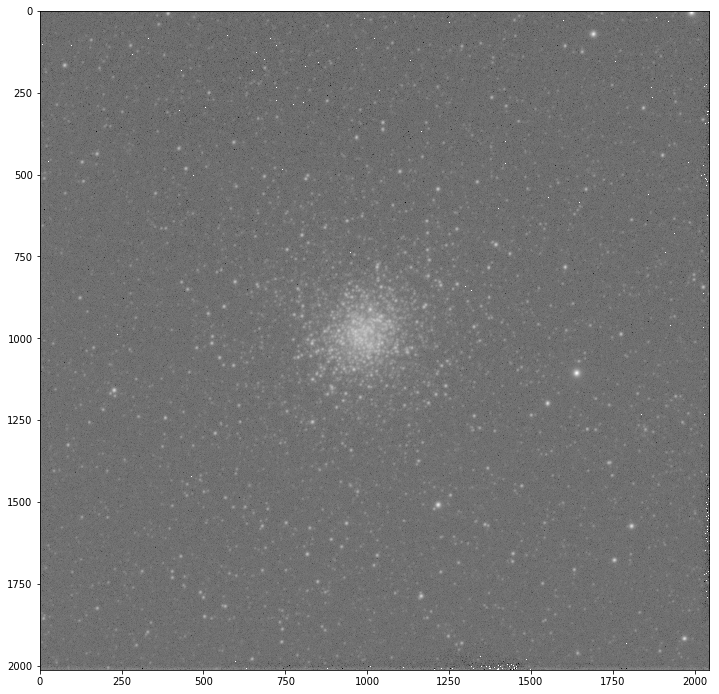

In [160]:
fig = plt.figure(figsize=(12,112))
ax1 = fig.add_subplot(111)

norm = LogNorm(vmin=0.01,vmax=3000)
ax1.imshow(combined_average, cmap='gray', norm=norm)

Great! Now we'll save out this image to a new fits file so we can look at it in ds9.

In [136]:
hdu = fits.PrimaryHDU(combined_average, header=canonical_wcs.to_header())
hdu.writeto("../data/v_mean_template_crr.fits", overwrite=True)

In [137]:
ds9viewer=imexam.connect('c0a80121:55228')
ds9viewer.scale("log")
ds9viewer.scale("minmax")

In [138]:
ds9viewer.load_fits("../data/mean_template_crr.fits")

In [140]:
ds9viewer.imexam()


Press 'q' to quit

2	Make the next plot in a new window
a	Aperture sum, with radius region_size 
b	Return the 2D gauss fit center of the object
c	Return column plot
e	Return a contour plot in a region around the cursor
g	Return curve of growth plot
h	Return a histogram in the region around the cursor
j	1D [Gaussian1D default] line fit 
k	1D [Gaussian1D default] column fit
l	Return line plot
m	Square region stats, in [region_size],default is median
r	Return the radial profile plot
s	Save current figure to disk as [plot_name]
t	Make a fits image cutout using pointer location
w	Display a surface plot around the cursor location
x	Return x,y,value of pixel
y	Return x,y,value of pixel
Current image /Users/cbrasseur/Documents/ljmu/CepheidVariables/data/mean_template_crr.fits


#### Saving aligned images

We'll save all the aligned images out so we can access them without having to do the alignment process again.

In [269]:
wcs_header = canonical_wcs.to_header()

In [88]:
for n,image in enumerate(template_images):
    if n == 5:
        continue
    header = image.initial_header
    for kwd in wcs_header:
        header[kwd] = wcs_header[kwd]
        
    hdu = fits.PrimaryHDU(image.corrected_image, header=header)
    hdu.writeto(image.filename.replace(".fits","_aligned.fits"))

I think the fwhm is also an average of the template image fwhms?

## Aligning the rest of the images to this template

I want to automate picking out the fixed stars in the image, because that's really labor intensive.
I'll start by looking for the stars in each image that are closest to the fixed stars and assuming those are a match.

In [294]:
def plot_fixed_stars(img, fixed_stars):

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    positions = (fixed_stars['x'], fixed_stars['y'])
    apertures = CircularAperture(positions, r=15.)
    norm = LogNorm(vmin=0.01,vmax=3000)
    ax.imshow(img, cmap='Greys', norm=norm, origin='lower')
    apertures.plot(color='red', lw=1.5, alpha=0.25)

In [174]:
fixed_stars = Table()

fixed_stars['ra'] = [78.28064,78.29842,78.36535,78.24656,78.25705,78.56488,78.27106]
fixed_stars['dec'] = [-65.45482,-65.44702,-65.421,-65.41576,-65.4071,-65.4497,-65.54136]
fixed_stars['coord'] = SkyCoord(fixed_stars['ra'], fixed_stars['dec'], unit=u.deg) # for wcs fitting

In [364]:
def align_file(fle, threshold=25):        
    print(fle)
    
    # read in the info we need
    hdu = fits.open(fle)
    img_data = hdu[0].data
    img_header = hdu[0].header
    img_wcs = WCS(hdu[0])
    hdu.close()
    
    mean, median, std = sigma_clipped_stats(img_data, sigma=3.0, iters=5)
    
    daofind = DAOStarFinder(fwhm=6.2, threshold=threshold*std) # Using a high threshold so we only get the brightest stars
    img_catalog = daofind(img_data - median)
    
    img_catalog['ra'],img_catalog['dec'] = img_wcs.wcs_pix2world(img_catalog['xcentroid'],img_catalog['ycentroid'],0)
    img_catalog['coord'] = SkyCoord(img_catalog['ra'], img_catalog['dec'], unit=u.deg)
    
    print("Number of sources in image:", len(img_catalog))
    
    # Getting the x,y coordinates of the fixed stars
    xs = []
    ys = []
    for star in fixed_stars:
        idx,_,_= star['coord'].match_to_catalog_sky(img_catalog['coord'])
        xs.append(img_catalog['xcentroid'][idx])
        ys.append(img_catalog['ycentroid'][idx])

    fixed_stars['x'] = xs
    fixed_stars['y'] = ys
    
    # sanity check plot
    plot_fixed_stars(img_data, fixed_stars)
    plt.show()
    
    # Getting the corrected wcs info
    corrected_wcs = pixworld2wcs.wcs_pixworld2wcs(fixed_stars['x','y','coord'])
    
    # Checking the histogram
    ras,decs = corrected_wcs.wcs_pix2world(img_catalog['xcentroid'],img_catalog['ycentroid'],0)
    imgcoords = SkyCoord(ras,decs,unit=u.deg)
    idx, d2d, d3d = gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['coord'].match_to_catalog_sky(imgcoords)
    plotSepHist(d2d)
    plt.show()
    
    # Plotting the brighter gaia sources over our image
    x,y = corrected_wcs.wcs_world2pix(gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['ra'],
                                      gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['dec'],0)
    plotSourcesOverImage(x,y,img_data)
    plt.show()
    
    # Performing alignment (note, canonical wcs and shape already set above)
    corrected_img, footprint = reproject_interp((img_data,corrected_wcs), canonical_wcs,canonical_shape)
    
    # Saving the aligned image to file
    for kwd in wcs_header:
        img_header[kwd] = wcs_header[kwd]
        
    hdu = fits.PrimaryHDU(corrected_img, header=img_header)
    hdu.writeto(fle.replace(".fits","_aligned.fits"),overwrite=True)
    

The indexes we used in the template: 3,13,15,16,18,30

../data/NGC1866_images/coj2m002-fs01-20151008-0155-e90.fits
Number of sources in image: 167


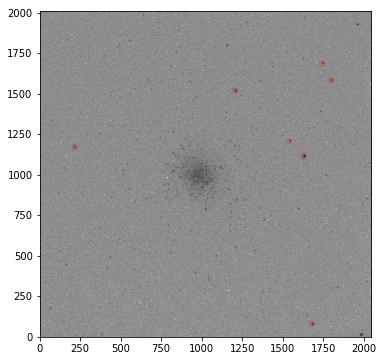

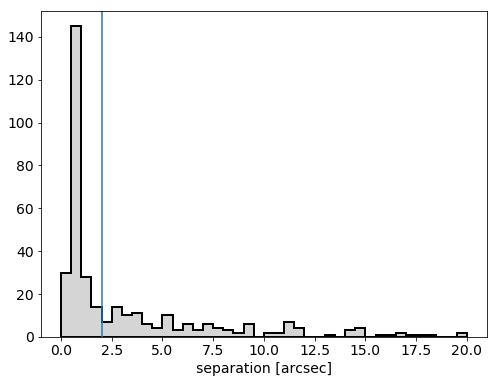

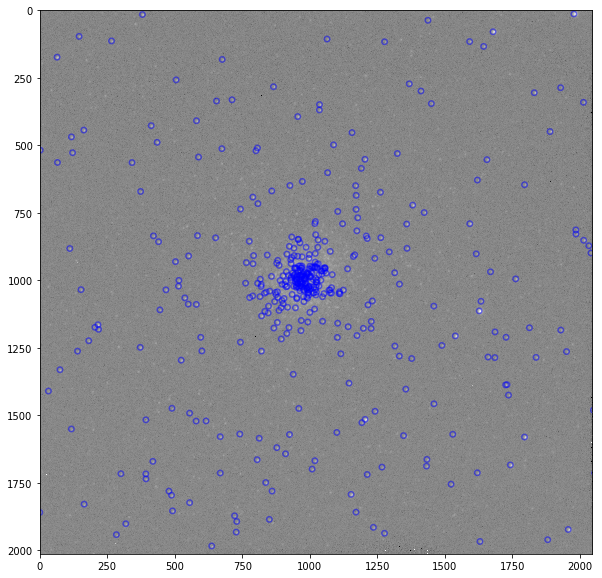

In [365]:
align_file(filesByWaveband['V'][2], threshold=50)